In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

## Read in Meta Json File

In [2]:
with open('metadata.json') as f:
    meta = json.load(f)

## Bounding Box Preprocessing

### Extracting Min and Max Coordinates

In [4]:
def minMax_xy(lod):
    max_x = max(lod, key=lambda x: x['x'])['x']
    min_x = min(lod, key=lambda x: x['x'])['x']
    max_y = max(lod, key=lambda x: x['y'])['y']
    min_y = min(lod, key=lambda x: x['y'])['y']
    return min_x, min_y, max_x, max_y

In [5]:
data = pd.DataFrame.from_dict(meta, orient="index")

data = data.reset_index().rename(columns={"index":"image_name"})

#select only image name column and x_y coordinate attribute
data = data[['image_name', 'bounds_x_y']]

data.head()

,image_name,bounds_x_y
0,42.7363609_2.8868181.png,"[{'x': 219.88854424638464, 'y': 197.9724640370..."
1,42.7008031_2.906998.png,"[{'x': 219.31757991040274, 'y': 223.9864984406..."
2,42.6892307_2.9110119.png,"[{'x': 258.80982304681845, 'y': 290.6887228406..."
3,44.5015552_0.1670612.png,"[{'x': 218.20287511855798, 'y': 215.7165834111..."
4,43.3741395_3.3383116.png,"[{'x': 299.5176070846709, 'y': 176.37075727338..."


In [8]:
box_coord = [minMax_xy(coord) for coord in list_of_bounds]
box_coord[:1]

[(199.24285541121722,
  197.97246403701524,
  312.75714461835867,
  286.02750490829436)]

In [9]:
coord_df = pd.DataFrame(box_coord, columns = ["min_x", "min_y", "max_x", "max_y"])
coord_df.head()

,min_x,min_y,max_x,max_y
0,199.242855,197.972464,312.757145,286.027505
1,217.024929,223.986498,294.975071,260.013496
2,215.627279,193.311239,296.298778,290.688723
3,218.202875,194.347944,293.873329,289.652020
4,177.638398,175.239218,334.361602,308.863578


## Create Dataset with Image Name and Bounding Box Coordinates

In [12]:
data_final = pd.concat([data[['image_name']], coord_df], axis=1)
data_final.head()

#some images in the meta list is missing
#cross reference those and eliminate from dataset
files = os.listdir('./images')
data = data[data['image_name'].isin(files)]
data.head()

data_final.to_csv("final_meta.csv", index=False)

## Split Data into Train, Test, and Validation

In [14]:
full_data = pd.read_csv("final_meta.csv")

X = full_data[['image_name']]
y = full_data.iloc[:,1:]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)


In [ ]:
#Don't run the following, as it may overwrite the current files
training_data = pd.concat([X_train, y_train], axis=1)
val_data  = pd.concat([X_val, y_val],axis=1)
test_data = pd.concat([X_test, y_test], axis=1)
training_data.to_csv("training_data.csv", index=False)
val_data.to_csv("val_data.csv",index=False)
test_data.to_csv("test_data.csv", index=False)

## Model 1

We reshape the image size to 200 x 200 to scale down the inputs and weights.

- 2 - convolutional layers of size 16
- 2 - Max Pooling Layers
- 4 - Hidden layers - Size 128,64,32,16

In [19]:
input_shape = (200, 200, 3)
input_layer = tf.keras.layers.Input(input_shape)
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_4')(base_layers)
# base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
# base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

#create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(16, activation='relu', name='bb_4')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)


In [22]:
model = tf.keras.Model(input_layer,outputs=locator_branch)
model.compile(loss={"bb_head":tf.keras.losses.MSE}, optimizer='Adam', metrics=['accuracy'])

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
bl_1 (Rescaling)             (None, 200, 200, 3)       0         
_________________________________________________________________
bl_2 (Conv2D)                (None, 200, 200, 16)      448       
_________________________________________________________________
bl_3 (MaxPooling2D)          (None, 100, 100, 16)      0         
_________________________________________________________________
bl_4 (Conv2D)                (None, 100, 100, 16)      2320      
_________________________________________________________________
bl_7 (MaxPooling2D)          (None, 50, 50, 16)        0         
_________________________________________________________________
bl_8 (Flatten)               (None, 40000)             0   

## Data Generator

Because the training data size is too big to fit onto memory, we need to build a data generator in tensorflow to feed in data in smaller batches so that training is possible


Note that the bounding box is scaled to 200 by 200 from 512 by 512.

Furthermore, to train the label, we divide by 200 so that the bounding box coordinates is between 0 and 1.

In [2]:

class DataGenerator(Sequence):
    def __init__(self, csv_file, base_dir, output_size, shuffle=False, batch_size=10):
        """
        Initializes a data generator object
            :param csv_file: file in which image names and numeric labels are stored
            :param base_dir: the directory in which all images are stored
            :param output_size: image output size after preprocessing
            :param shuffle: shuffle the data after each epoch
            :param batch_size: The size of each batch returned by __getitem__
        """
        self.df = pd.read_csv(csv_file)
        self.base_dir = base_dir
        self.output_size = output_size
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.on_epoch_end()
    

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        ## Initializing Batch
        #  that one in the shape is just for a one channel images
        # if you want to use colored images you might want to set that to 3
        X = np.empty((self.batch_size, *self.output_size, 3))
        #(x, y, h, w)
        y = np.empty((self.batch_size, 4))

        #get the indices of the requested batch
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        for i, data_index in enumerate(indices):

            img_path = os.path.join(self.base_dir, self.df.iloc[data_index, 0])
            train_img = keras.preprocessing.image.load_img(img_path, target_size=(200, 200))
            train_img_arr = keras.preprocessing.image.img_to_array(train_img)

            scale = 200 / 512

            label_lst = self.df.iloc[data_index, 1:].tolist()

            label = np.array([round((i*scale)/200,2) for i in label_lst])


            ## if you have any preprocessing for
            ## the labels too do it here

            X[i,] = train_img_arr
            y[i] = label

        return X,y


### Create a Generator for Training and Validation Set

In [3]:
train_gen = DataGenerator("training_data.csv", "images", (200, 200), batch_size=16, shuffle=True)
val_gen = DataGenerator("val_data.csv", "images", (200, 200), batch_size=32, shuffle=True)

## Fit the Model

10 epochs

In [ ]:
model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
712/712 [==============================] - 346s 486ms/step - loss: 3.9352e-04 - accuracy: 0.9098 - val_loss: 2.6376e-04 - val_accuracy: 0.9095
Epoch 2/10
712/712 [==============================] - 351s 492ms/step - loss: 2.5693e-04 - accuracy: 0.9145 - val_loss: 2.3696e-04 - val_accuracy: 0.9119
Epoch 3/10
712/712 [==============================] - 388s 544ms/step - loss: 2.2445e-04 - accuracy: 0.9192 - val_loss: 2.3393e-04 - val_accuracy: 0.9167
Epoch 4/10
712/712 [==============================] - 362s 509ms/step - loss: 1.8498e-04 - accuracy: 0.9228 - val_loss: 2.3703e-04 - val_accuracy: 0.8710
Epoch 5/10
712/712 [==============================] - 347s 487ms/step - loss: 1.4253e-04 - accuracy: 0.9272 - val_loss: 2.5257e-04 - val_accuracy: 0.8766
Epoch 6/10
712/712 [==============================] - 380s 534ms/step - loss: 1.7655e-04 - accuracy: 0.9237 - val_loss: 2.7520e-04 - val_accuracy: 0.8870
Epoch 7/10
712/712 [==============================] - 360s 505ms/step - loss

In [ ]:
#save model
model.save("saved_model/model1")

In [27]:
#how to load saved model
model = tf.keras.models.load_model('saved_model/model1')

## Preprocess Test Data

In [4]:
# Process Test Data 
#test

test_CSV_FILE = 'test_data.csv'
IMAGE_DIR = 'images\\'

test_image_records = pd.read_csv(test_CSV_FILE)

image_path = os.path.join(os.getcwd(), IMAGE_DIR)

test_images = []
test_targets = []


for index, row in test_image_records.iterrows():
    

    (filename, xmin, ymin, xmax, ymax) = row

    test_image_fullpath = os.path.join(image_path, filename)
    test_img = keras.preprocessing.image.load_img(test_image_fullpath, target_size=(200, 200))
    test_img_arr = keras.preprocessing.image.img_to_array(test_img)
    
    scale = 200 / 512

    xmin = round((xmin * scale), 2)
    ymin = round((ymin * scale), 2)
    xmax = round((xmax * scale), 2)
    ymax = round((ymax * scale), 2)


    test_images.append(test_img_arr)
    test_targets.append((xmin, ymin, xmax, ymax))

## Making Predictions


Since the model outputs bounding box values from 0 to 1, we need to scale it up by a factor of 200 (the original resize dimensions - width and height).

In [39]:
test_img = test_images[1]

img = tf.expand_dims(test_img, 0)

model.predict(img) 

#scale prediction into pixels
pred = model.predict(img)[0].tolist()

coord = [200* x for x in pred]
coord

[83.33578705787659, 82.57365226745605, 115.93422889709473, 106.49851560592651]

View the Prediction vs Actual

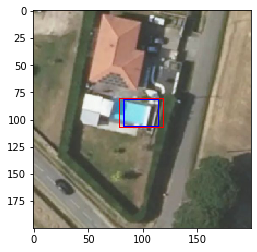

In [40]:
test_img=test_images[1]
pil_img = tf.keras.preprocessing.image.array_to_img(test_img)

new_coord = test_targets[1]

start_point = (new_coord[0], new_coord[3])
end_point = (new_coord[2], new_coord[1])

start_point_pred = (coord[0], coord[3])
end_point_pred = (coord[2], coord[1])
draw = PIL.ImageDraw.Draw(pil_img)
draw.rectangle((start_point, end_point), outline="red")
draw.rectangle((start_point_pred, end_point_pred), outline="blue")
plt.imshow(pil_img)

# Intersection of Union Function

To calculate how well the predicting bounding box is, we use the intersection of union metric. This metric is a number between 0 and 1 that indicates the common proportion between the true bounding box and the predicted bounding box.

In [5]:
def get_iou(coord1, coord2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        {x1:x_min, y1:y_max, x2:x_max, y2:y_min}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    bb1 = {}
    bb2 = {}
    bb1['x1'] = coord1[0]
    bb1['x2'] = coord1[2]
    bb1['y1'] = coord1[1]
    bb1['y2'] = coord1[3]
    bb2['x1'] = coord2[0]
    bb2['x2'] = coord2[2]
    bb2['y1'] = coord2[1]
    bb2['y2'] = coord2[3]


    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
print(coord)
print(test_targets[1])

In [51]:
get_iou(coord, test_targets[1])

0.7407856354908184

In [52]:
y_pred = model.predict(np.array(test_images)) * 200
print(y_pred[:4])

[[ 85.28777   81.91222  114.15912  106.957886]
 [ 83.33579   82.573654 115.93423  106.49851 ]
 [ 83.274796  80.12645  116.82248  108.3277  ]
 [ 88.42361   79.40322  110.88236  108.792816]]


In [53]:
test_targets[:4]

[(82.81, 79.3, 116.8, 109.38),
 (79.69, 81.25, 119.92, 107.42),
 (83.2, 79.3, 116.41, 109.38),
 (85.55, 83.59, 114.06, 104.69)]

In [54]:
iou_lst = [get_iou(pred, true) for pred,true in zip(y_pred,test_targets)]

# Mean IoU for Model 1

In [57]:
np.mean(iou_lst)

0.7269411285585954

## Model 2 - Less layers

In [6]:
input_shape = (200, 200, 3)
input_layer = tf.keras.layers.Input(input_shape)
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(8, 3, padding='same', activation='relu', name='bl_4')(base_layers)
# base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
# base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

#create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

model2 = tf.keras.Model(input_layer,outputs=locator_branch)
model2.compile(loss={"bb_head":tf.keras.losses.MSE}, optimizer='Adam', metrics=['accuracy'])
model2.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
bl_1 (Rescaling)             (None, 200, 200, 3)       0         
_________________________________________________________________
bl_2 (Conv2D)                (None, 200, 200, 16)      448       
_________________________________________________________________
bl_3 (MaxPooling2D)          (None, 100, 100, 16)      0         
_________________________________________________________________
bl_4 (Conv2D)                (None, 100, 100, 8)       1160      
_________________________________________________________________
bl_7 (MaxPooling2D)          (None, 50, 50, 8)         0         
_________________________________________________________________
bl_8 (Flatten)               (None, 20000)             0   

In [7]:
model2.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
712/712 [==============================] - 266s 374ms/step - loss: 8.7931e-04 - accuracy: 0.9064 - val_loss: 3.6298e-04 - val_accuracy: 0.9038
Epoch 2/10
712/712 [==============================] - 324s 456ms/step - loss: 2.9789e-04 - accuracy: 0.9159 - val_loss: 3.0769e-04 - val_accuracy: 0.9135
Epoch 3/10
712/712 [==============================] - 334s 469ms/step - loss: 2.4262e-04 - accuracy: 0.9165 - val_loss: 2.3632e-04 - val_accuracy: 0.9199
Epoch 4/10
712/712 [==============================] - 381s 536ms/step - loss: 2.1267e-04 - accuracy: 0.9230 - val_loss: 2.5047e-04 - val_accuracy: 0.9087
Epoch 5/10
712/712 [==============================] - 302s 424ms/step - loss: 1.8089e-04 - accuracy: 0.9254 - val_loss: 2.5600e-04 - val_accuracy: 0.8902
Epoch 6/10
712/712 [==============================] - 312s 438ms/step - loss: 1.5363e-04 - accuracy: 0.9260 - val_loss: 2.3580e-04 - val_accuracy: 0.8958
Epoch 7/10
712/712 [==============================] - 284s 399ms/step - loss

In [8]:
#save model
model2.save("saved_model/model2")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/model2\assets


In [15]:
#load model
model2 = tf.keras.models.load_model('saved_model/model2')

In [16]:
y_pred2 = model2.predict(np.array(test_images)) * 200

In [17]:
iou_lst = [get_iou(pred, true) for pred,true in zip(y_pred2,test_targets)]
np.mean(iou_lst)

0.7415830926426682

# Model 3

In [12]:
input_shape = (200, 200, 3)
input_layer = tf.keras.layers.Input(input_shape)
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

#create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(16, activation='relu', name='bb_4')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

model3 = tf.keras.Model(input_layer,outputs=locator_branch)
model3.compile(loss={"bb_head":tf.keras.losses.MSE}, optimizer='Adam', metrics=['accuracy'])
model3.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
bl_1 (Rescaling)             (None, 200, 200, 3)       0         
_________________________________________________________________
bl_2 (Conv2D)                (None, 200, 200, 16)      448       
_________________________________________________________________
bl_3 (MaxPooling2D)          (None, 100, 100, 16)      0         
_________________________________________________________________
bl_4 (Conv2D)                (None, 100, 100, 32)      4640      
_________________________________________________________________
bl_5 (MaxPooling2D)          (None, 50, 50, 32)        0         
_________________________________________________________________
bl_6 (Conv2D)                (None, 50, 50, 64)        18496 

In [13]:
model3.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
712/712 [==============================] - 463s 651ms/step - loss: 4.2210e-04 - accuracy: 0.9061 - val_loss: 2.4589e-04 - val_accuracy: 0.9127
Epoch 2/10
712/712 [==============================] - 446s 627ms/step - loss: 2.5951e-04 - accuracy: 0.9159 - val_loss: 2.2551e-04 - val_accuracy: 0.9199
Epoch 3/10
712/712 [==============================] - 332s 466ms/step - loss: 2.1558e-04 - accuracy: 0.9199 - val_loss: 1.8253e-04 - val_accuracy: 0.9062
Epoch 4/10
712/712 [==============================] - 335s 471ms/step - loss: 1.8348e-04 - accuracy: 0.9269 - val_loss: 1.7950e-04 - val_accuracy: 0.9271
Epoch 5/10
712/712 [==============================] - 357s 502ms/step - loss: 1.6195e-04 - accuracy: 0.9335 - val_loss: 1.6783e-04 - val_accuracy: 0.9183
Epoch 6/10
712/712 [==============================] - 418s 587ms/step - loss: 1.4326e-04 - accuracy: 0.9360 - val_loss: 1.8036e-04 - val_accuracy: 0.8838
Epoch 7/10
712/712 [==============================] - 414s 581ms/step - loss

In [14]:
model3.save("saved_model/model3")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/model3\assets


In [6]:
model3 = tf.keras.models.load_model('saved_model/model3')
y_pred3 = model3.predict(np.array(test_images)) * 200

In [8]:
iou_lst3 = [get_iou(pred, true) for pred,true in zip(y_pred3,test_targets)]
np.mean(iou_lst3)

0.7768114981483802

## Try out Different Optimizers

Here we try to fit two different models using the same architecture as model 3, but with different optimizers to see if we can improve the mean test IoU metric.

In [9]:
input_shape = (200, 200, 3)
input_layer = tf.keras.layers.Input(input_shape)
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

#create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(16, activation='relu', name='bb_4')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

model4 = tf.keras.Model(input_layer,outputs=locator_branch)
model4.compile(loss={"bb_head":tf.keras.losses.MSE}, optimizer='SGD', metrics=['accuracy'])
model4.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
bl_1 (Rescaling)             (None, 200, 200, 3)       0         
_________________________________________________________________
bl_2 (Conv2D)                (None, 200, 200, 16)      448       
_________________________________________________________________
bl_3 (MaxPooling2D)          (None, 100, 100, 16)      0         
_________________________________________________________________
bl_4 (Conv2D)                (None, 100, 100, 32)      4640      
_________________________________________________________________
bl_5 (MaxPooling2D)          (None, 50, 50, 32)        0         
_________________________________________________________________
bl_6 (Conv2D)                (None, 50, 50, 64)        18496 

In [11]:
model4.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
712/712 [==============================] - 291s 408ms/step - loss: 9.7768e-04 - accuracy: 0.9005 - val_loss: 6.1719e-04 - val_accuracy: 0.9014
Epoch 2/10
712/712 [==============================] - 296s 415ms/step - loss: 6.4315e-04 - accuracy: 0.9098 - val_loss: 5.9342e-04 - val_accuracy: 0.9014
Epoch 3/10
712/712 [==============================] - 303s 425ms/step - loss: 6.2991e-04 - accuracy: 0.9098 - val_loss: 5.9003e-04 - val_accuracy: 0.9030
Epoch 4/10
712/712 [==============================] - 304s 427ms/step - loss: 6.2437e-04 - accuracy: 0.9098 - val_loss: 5.8382e-04 - val_accuracy: 0.8998
Epoch 5/10
712/712 [==============================] - 305s 428ms/step - loss: 6.1905e-04 - accuracy: 0.9098 - val_loss: 5.7638e-04 - val_accuracy: 0.9038
Epoch 6/10
712/712 [==============================] - 306s 430ms/step - loss: 6.1491e-04 - accuracy: 0.9101 - val_loss: 5.7728e-04 - val_accuracy: 0.9038
Epoch 7/10
712/712 [==============================] - 307s 431ms/step - loss

In [12]:
model4.save("saved_model/model4")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/model4\assets


In [13]:
model4 = tf.keras.models.load_model('saved_model/model4')
y_pred4 = model4.predict(np.array(test_images)) * 200

In [14]:
iou_lst4 = [get_iou(pred, true) for pred,true in zip(y_pred4,test_targets)]
np.mean(iou_lst4)

0.6236871554449994

In [15]:
input_shape = (200, 200, 3)
input_layer = tf.keras.layers.Input(input_shape)
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

#create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(16, activation='relu', name='bb_4')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

model5 = tf.keras.Model(input_layer,outputs=locator_branch)
model5.compile(loss={"bb_head":tf.keras.losses.MSE}, optimizer='RMSprop', metrics=['accuracy'])
model5.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
bl_1 (Rescaling)             (None, 200, 200, 3)       0         
_________________________________________________________________
bl_2 (Conv2D)                (None, 200, 200, 16)      448       
_________________________________________________________________
bl_3 (MaxPooling2D)          (None, 100, 100, 16)      0         
_________________________________________________________________
bl_4 (Conv2D)                (None, 100, 100, 32)      4640      
_________________________________________________________________
bl_5 (MaxPooling2D)          (None, 50, 50, 32)        0         
_________________________________________________________________
bl_6 (Conv2D)                (None, 50, 50, 64)        1849

In [16]:
model5.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
712/712 [==============================] - 424s 596ms/step - loss: 5.7887e-04 - accuracy: 0.9049 - val_loss: 2.2600e-04 - val_accuracy: 0.9030
Epoch 2/10
712/712 [==============================] - 414s 581ms/step - loss: 2.5995e-04 - accuracy: 0.9202 - val_loss: 1.8273e-04 - val_accuracy: 0.9143
Epoch 3/10
712/712 [==============================] - 425s 597ms/step - loss: 2.1417e-04 - accuracy: 0.9219 - val_loss: 3.3348e-04 - val_accuracy: 0.9391
Epoch 4/10
712/712 [==============================] - 418s 588ms/step - loss: 1.8603e-04 - accuracy: 0.9268 - val_loss: 1.7489e-04 - val_accuracy: 0.9119
Epoch 5/10
712/712 [==============================] - 379s 533ms/step - loss: 1.5455e-04 - accuracy: 0.9297 - val_loss: 1.7461e-04 - val_accuracy: 0.8966
Epoch 6/10
712/712 [==============================] - 344s 483ms/step - loss: 1.2729e-04 - accuracy: 0.9337 - val_loss: 1.7150e-04 - val_accuracy: 0.9247
Epoch 7/10
712/712 [==============================] - 340s 478ms/step - loss

In [17]:
model5.save("saved_model/model5")

INFO:tensorflow:Assets written to: saved_model/model5\assets


In [84]:
model5 = tf.keras.models.load_model('saved_model/model5')
y_pred5 = model5.predict(np.array(test_images)) * 200

In [22]:
iou_lst5 = [get_iou(pred, true) for pred,true in zip(y_pred5,test_targets)]
np.mean(iou_lst5)

0.7798527738710971

# Transfer Learning

In [23]:
vgg = tf.keras.applications.VGG16(input_shape=[200, 200, 3], include_top=False, weights='imagenet')

58892288/58889256 [==============================] - 10s 0us/step


In [36]:
# adding layers to the vgg model

base_layers = layers.Flatten()(vgg.output)
# locator_branch = layers.Dense(32, activation='relu', name='bb_1')(base_layers)
# locator_branch = layers.Dense(16, activation='relu', name='bb_2')(locator_branch)
# locator_branch = layers.Dense(8, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid')(base_layers)

tf_model1 = Model(vgg.input, locator_branch)
tf_model1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=["accuracy"])
tf_model1.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0  

In [38]:
tf_model1.fit(train_gen, epochs=1, validation_data=val_gen)

712/712 [==============================] - 8625s 12s/step - loss: 0.6811 - accuracy: 0.8935 - val_loss: 0.6808 - val_accuracy: 0.8998


In [39]:
tf_model1.save("saved_model/model6_tf")

INFO:tensorflow:Assets written to: saved_model/model6_tf\assets


In [40]:
tf_model1 = tf.keras.models.load_model('saved_model/model6_tf')
y_pred6 = tf_model1.predict(np.array(test_images)) * 200

In [41]:
iou_lst6 = [get_iou(pred, true) for pred,true in zip(y_pred6,test_targets)]
np.mean(iou_lst6)

0.6280322446613902

## Function to Draw Bounding Boxes

In [45]:
y_pred6[0].tolist()

[86.75814819335938, 81.38105010986328, 113.33935546875, 108.23118591308594]

In [74]:
def draw_box(idx, pred_arr,pred=False):
    """
    takes in an img_idx
    """
    img = test_images[idx]
    #transform img to array
    pil_img = tf.keras.preprocessing.image.array_to_img(img)
    true_coord = test_targets[idx]
    start_point_true = (true_coord[0], true_coord[3])
    end_point_true = (true_coord[2], true_coord[1])

    draw = PIL.ImageDraw.Draw(pil_img)   

    if pred:
        #scale prediction into pixels
        pred_coord = pred_arr[0].tolist()
        start_point_pred = (pred_coord[0], pred_coord[3])
        end_point_pred = (pred_coord[2], pred_coord[1])
        draw.rectangle((start_point_pred, end_point_pred), outline="blue")

    
    #draw true bounding box
    draw.rectangle((start_point_true, end_point_true), outline="red")
    

    return plt.imshow(pil_img)
    

## Prediction box of Model 6 on Image 1 Vs the Actual

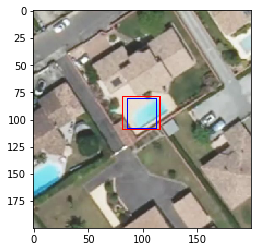

In [75]:
draw_box(0, y_pred6, pred=True)

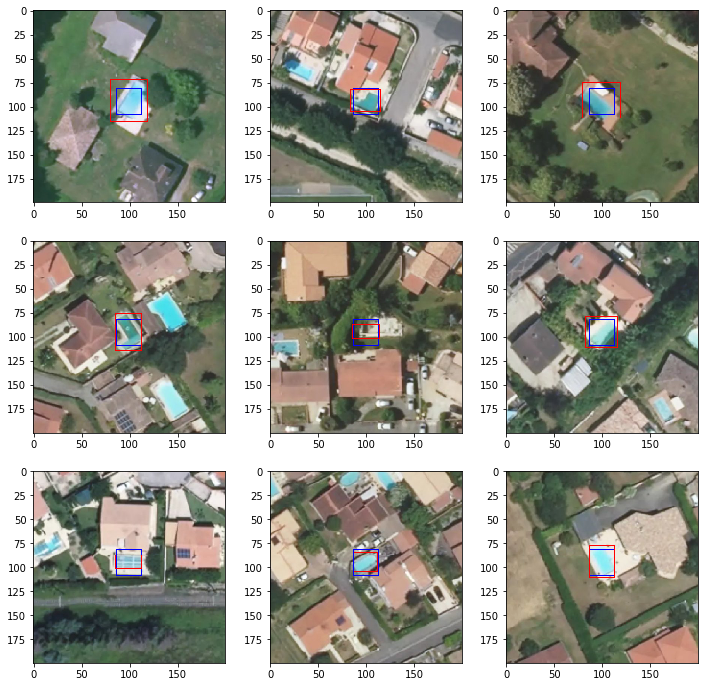

In [83]:
import random

w = 10
h = 10
fig = plt.figure(figsize=(12, 12))
columns = 3
rows = 3
#generate a list of random integers in range of test length
rand_idx = [random.randint(0, len(test_targets)-1) for i in range(columns*rows)]

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw_box(rand_idx[i-1], y_pred6, pred=True)
fig.savefig('transfer_learning.png')

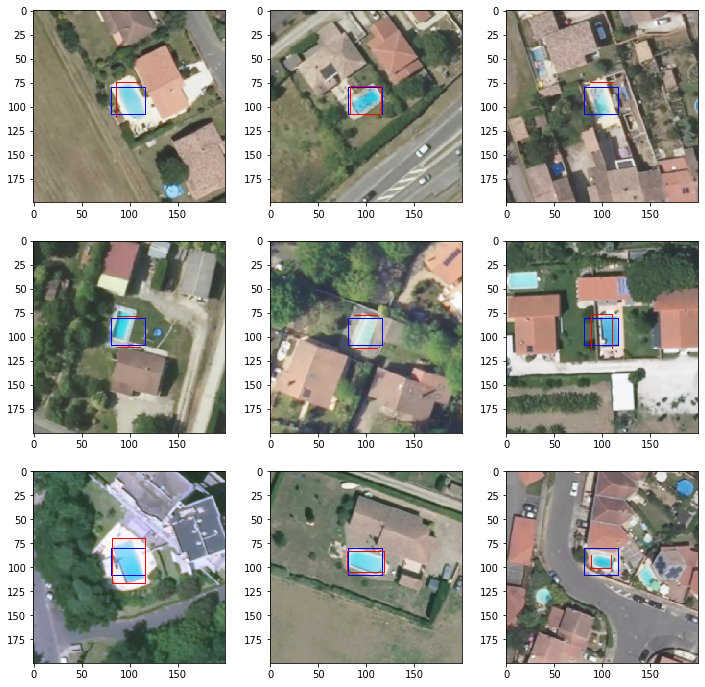

In [86]:
import random

w = 10
h = 10
fig = plt.figure(figsize=(12, 12))
columns = 3
rows = 3
#generate a list of random integers in range of test length
rand_idx = [random.randint(0, len(test_targets)-1) for i in range(columns*rows)]

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw_box(rand_idx[i-1], y_pred5, pred=True)
fig.savefig('RMSpropModel5.png')